# PCA to find a measure of maximun topological variance  
Analysis of Network Topology correlation with Free Text (DOIs) over different snapshots.
Followed by an anaylsis of DOIs and their associated personality.

In [2]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib import colors as mcolors

plt.rcParams.update({'font.size': 26})
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

snaps=[19]
k=1 #statistic SEM
# Free text associated with personality trais and gender
doi2per = pd.read_csv('Data/doi2big5.csv')
doi2gen = pd.read_csv('Data/doi2gender.csv')
doi2met = pd.read_csv('Data/doi2meta.csv')

# PCA Analysis
for snap in snaps:
    plt.clf()
    dataset = pd.read_csv('Data/snap_{}_dois_100.csv'.format(snap),index_col=0)    
    norm_data = preprocessing.scale(dataset)
    pca = PCA()
    pca.fit(norm_data)
    pca_data = pca.transform(norm_data)

    ## exploring PCs
    exp_var = np.round(pca.explained_variance_ratio_ *100, decimals=1)
    features_w = np.round(pca.components_  *100, decimals=1)
    labels = ['PC' + str(n) for n in range(1,len(exp_var)+1)]       
    pca_df = pd.DataFrame(pca_data, columns=labels,index=dataset.index)
    
    ### to find the variance of PCs and contribution (by scores) of features on each 
    print(features_w[0:3])
    
    ###### PCA over DOIs ######
    plt.scatter(pca_df.PC1,pca_df.PC3, facecolors='none', edgecolors='k')
    plt.xlabel(f'PC1 - {exp_var[0]}%')
    plt.ylabel(f'PC3 - {exp_var[2]}%')
    
    dois_list = ['music','movies','reading','writing','art','books']
    for doi in pca_df.index:
        if doi in dois_list:
            plt.annotate(doi,(pca_df.PC1.loc[doi], pca_df.PC3.loc[doi]),fontsize=12,xytext=(-20,20), 
                textcoords='offset points', ha='center', va='bottom',
                bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', color='red'))
        elif doi == 'photography' or doi=='friends':
            plt.annotate(doi,(pca_df.PC1.loc[doi], pca_df.PC3.loc[doi]),fontsize=12,xytext=(-30,-30), 
                textcoords='offset points', ha='center', va='bottom',bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', color='red'))
            
    plt.savefig(f'Results/DOIs_{snap}')
    
    ###### Traits and DOIs associations ######
    fig, ax = plt.subplots(2,1,figsize=(12,10))  
    
    #### PC change??
    ax[0].scatter(pca_df.PC1,pca_df.PC2, facecolors='none', edgecolors='k')
    ax[0].set_xlabel(f'PC1 ({exp_var[0]}%)[AU]') 
    ax[0].set_ylabel(f'PC2 ({exp_var[1]}%)[AU]') #### here also var
    ax[0].set_aspect('equal')
    
    #ax[1].scatter(pca_df.PC1,pca_df.PC3,c='k')
    ax[1].set_xlabel(f'PC1 - {exp_var[0]}%')
    ax[1].set_ylabel(f'PC3 - {exp_var[2]}%')
    #ax[1].set_aspect('equal')

    c = ['b', 'r']
    bs=['Plasticity','Stability']
    for i,b in enumerate(bs):
        x = []
        y= []
        for doi in doi2met['DOIs']:
            if doi2met.loc[doi2met['DOIs'] == doi,'Meta'].iloc[0] == b:
                x.append(pca_df.PC1.loc[doi])
                y.append(pca_df.PC2.loc[doi])### here
        
        xerror = k * np.std(x,ddof=1) / np.sqrt(len(x))
        yerror = k * np.std(y,ddof=1) / np.sqrt(len(y))        

        #ax[0].annotate(b,(np.mean(x), np.mean(y)),color=colors[c[i]],label=b)
        ax[0].errorbar(np.mean(x), np.mean(y), xerr=xerror, yerr=yerror, capsize=3, ls='none', color=c[i], elinewidth=4, label=b)
    print('----PC1 vs. PC3: meta-traits----')
        #print(f'{b}-mean:{np.mean(x):.3f}-{np.mean(y):.3f}, SEM:{xerror:.3f}-{yerror:.3f}')
    
    ax[0].legend(bbox_to_anchor=(1., 1), loc=2, borderaxespad=0.)
    ax[0].set_xlim(-10, 10)
    ax[0].set_ylim(-5, 5)
 
    c = ['b','midnightblue','red', 'darkred','indianred']
    bs = ['Extraversion','Openness to Exp.','Conscientiousness','Agreeableness','Neuroticism']
    
    for i, b in enumerate(bs):
        x = []
        y= []
        for doi in doi2per['DOIs']:
            if doi2per.loc[doi2per['DOIs'] == doi,'Traits'].iloc[0] == b:
                x.append(pca_df.PC1.loc[doi])
                y.append(pca_df.PC3.loc[doi])
                
        xerror = k * np.std(x,ddof=1) / np.sqrt(len(x))
        yerror = k * np.std(y,ddof=1) / np.sqrt(len(y))
        
        #ax[1].annotate(b,(np.mean(x), np.mean(y)),color=colors[c[i]],label=b)
        ax[1].errorbar(np.mean(x), np.mean(y), xerr=xerror, yerr=yerror, capsize=3, ls='none', color=colors[c[i]], elinewidth=4, label=b)
        print('----PC1 vs. PC3: personality traits----')
        #print(f'{b}-mean PCA1:{np.mean(x):.3f}-PCA3{np.mean(y):.3f}\nSEM:{xerror:.3f}-{yerror:.3f}')

    plt.legend(bbox_to_anchor=(1., 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(f'Results/DOIs_Traits_{snap}')
    
    ###### Gender and DOIs associations ######
    plt.clf()
    #plt.scatter(pca_df.PC1,pca_df.PC2, facecolors='none', edgecolors='k')
    plt.xlabel(f'PC1 - {exp_var[0]}%')
    plt.ylabel(f'PC2 - {exp_var[1]}%')
    
    colors = ['g', 'orange']
    for i,b in enumerate(set(doi2gen['Gender'])):
        x = []
        y= []
        for doi in doi2gen['DOIs']:
            if doi2gen.loc[doi2gen['DOIs'] == doi,'Gender'].iloc[0] == b:
                x.append(pca_df.PC1.loc[doi])
                y.append(pca_df.PC2.loc[doi])
                
        xerror = k * np.std(x,ddof=1) / np.sqrt(len(x))
        yerror = k * np.std(y,ddof=1) / np.sqrt(len(y))
    
        #plt.annotate(b,(np.mean(x), np.mean(y)),color=colors[i],label=b)
        plt.errorbar(np.mean(x), np.mean(y), xerr=xerror, yerr=yerror, capsize=3, ls='none', color=colors[i], elinewidth=4,label=b)
        
        print('----PC1 vs. PC2:gender----')
        #print(f'{b}-mean:{np.mean(x):.3f}-{np.mean(y):.3f}, SEM:{xerror:.3f}-{yerror:.3f}')
                    
    plt.xlim(-4, 3)
    plt.ylim(-2, 2)
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(f'Results/DOIs_Gender_{snap}')
    #pca_df.to_csv('pcadata.csv')



[[ 26.5  25.9  20.1   2.   15.5  26.8  28.   24.9  23.9  27.2  25.7  20.4
   22.1  27.8  25.3  -7.9  16.2  24.7  25.2]
 [ 14.8  16.9  30.4  42.2  35.7  -5.9   6.1 -16.5 -22.1   3.5 -14.1 -29.3
  -13.2  -2.7  18.7 -40.9 -31.6 -18.    9.4]
 [ -4.5  -8.4 -16.6  15.7  -2.2  26.    4.7  28.5  13.9 -19.1  25.6  18.1
  -46.3  14.3  -9.7 -26.3 -38.7  19.9 -36.2]]
----PC1 vs. PC3: meta-traits----
----PC1 vs. PC3: personality traits----
----PC1 vs. PC3: personality traits----
----PC1 vs. PC3: personality traits----
----PC1 vs. PC3: personality traits----
----PC1 vs. PC3: personality traits----
----PC1 vs. PC2:gender----
----PC1 vs. PC2:gender----


calculating mean+-SEM of Stability
calculating mean+-SEM of Plasticity


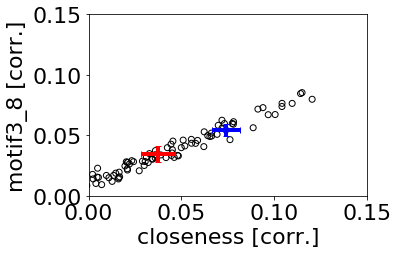

In [13]:
# how features span DOIs
snaps=[19]
k=1
#plt.rcParams.update({'font.size': 22})

for snap in snaps:
    dataset = pd.read_csv('Data/snap_{}_dois_100.csv'.format(snap),index_col=0)
    ###### Fetures and DOIs associations ######
    plt.scatter(dataset.closeness_1,dataset.motifs_3_8, facecolors='none', edgecolors='k')
    plt.ylabel('motif3_8 [corr.]')
    plt.xlabel('closeness [corr.]')
    
    colors = ['r', 'b']
    bs=['Stability','Plasticity']
    for i,b in enumerate(bs):
        x = []
        y= []
        for doi in doi2met['DOIs']:
            if doi2met.loc[doi2met['DOIs'] == doi,'Meta'].iloc[0] == b:
                x.append(dataset.closeness_1.loc[doi])
                y.append(dataset.motifs_3_8.loc[doi])
                
        xerror = k * np.std(x,ddof=1) / np.sqrt(len(x))
        yerror = k * np.std(y,ddof=1) / np.sqrt(len(y))
        
        #ax[0,0].annotate(b,(np.mean(x), np.mean(y)),color=colors[i],fontsize=22,xytext=(-20,20), textcoords='offset points', ha='center', va='bottom',bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3), arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', color='k'))
        plt.errorbar(np.mean(x), np.mean(y), xerr=xerror, yerr=yerror, capsize=3, ls='none', color=colors[i], elinewidth=4,label=b)
        print(f'calculating mean+-SEM of {b}')
        #print(f'{b}-mean:{np.mean(x):.3f}-{np.mean(y):.3f}, SEM:{xerror:.3f}-{yerror:.3f}')
    plt.xlim(0, 0.15)
    plt.ylim(0, 0.15)
    np.set_printoptions(precision=1)
    #plt.legend(bbox_to_anchor=(1.00, 1), loc=3, borderaxespad=0.3)
    plt.tight_layout()
    
    plt.savefig(f'Results/features_{snap}')

In [ ]:

'''
#the same analysis for exploring features
fig, ax = plt.subplots(figsize=(14,10), nrows=2, ncols=1)    
## PCA analysis for explaining the main clusters of features
norm_data2 = preprocessing.scale(dataset.T)
pca2 = PCA()
pca2.fit(norm_data2)
pca_data2 = pca2.transform(norm_data2)

## exploring number of PC affect on variance
exp_var2 = np.round(pca2.explained_variance_ratio_ *100, decimals=1)
labels = ['PC' + str(n) for n in range(1,len(exp_var2)+1)]
ax[0].bar(x=range(1,len(exp_var2)+1),height=exp_var2, tick_label=labels,color='b')
ax[0].set_ylabel('percentaeg of explained Variance')
ax[0].set_xlabel('PC')
ax[0].set_title(f'PCA Analysis snap:{snap}\nScree Plot - 2 main PCs')        

#main PC
pca_df2 = pd.DataFrame(pca_data2, columns=labels,index=dataset.columns)
ax[1].scatter(pca_df2.PC1,pca_df2.PC2)
ax[1].set_title(f'PCA Analysis')
ax[1].set_xlabel(f'PC1 - {exp_var[0]}%')
ax[1].set_ylabel(f'PC2 - {exp_var[1]}%')

for feature in pca_df2.index:
    ax[1].annotate(feature,(pca_df2.PC1.loc[feature], pca_df2.PC2.loc[feature]))
plt.savefig(f'Results/Features_PCA_{snap}')
    '''